# **Deepfake Detection Using CNN**

**Importing all necessary libraries**

In [ ]:
import dlib
import cv2
import os
import json
from PIL import Image, ImageChops, ImageEnhance

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras_preprocessing
from keras_preprocessing import image
import shutil


from tensorflow.keras.models import Model

**Mount the drive to colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
len(os.listdir("/content/drive/MyDrive/DATA/140K_data/real_vs_fake/real-vs-fake/train/real"))

15231

**Capturing images from the vidoes. Using the metadata, splitting the images into two labels named "fake" and "real".**

In [ ]:
train_frame_folder = '/content/drive/MyDrive/DATA/dfdc_train_part_05/dfdc_train_part_5'

meta_path = ""

for i in os.listdir(train_frame_folder):
    if i.split(".")[1] == "json":
        meta_path = train_frame_folder + "/" + i

with open(os.path.join(train_frame_folder, meta_path), 'r') as file:
    data = json.load(file)
list_of_train_data = [f for f in os.listdir(train_frame_folder) if f.endswith('.mp4')]
detector = dlib.get_frontal_face_detector()
for vid in list_of_train_data:
    count = 0
    cap = cv2.VideoCapture(os.path.join(train_frame_folder, vid))
    frameRate = cap.get(5)
    while cap.isOpened():
        frameId = cap.get(1)
        ret, frame = cap.read()
        if ret != True:
            break
        if frameId % ((int(frameRate)+1)*1) == 0:
            face_rects, scores, idx = detector.run(frame, 0)
            for i, d in enumerate(face_rects):
                x1 = d.left()
                y1 = d.top()
                x2 = d.right()
                y2 = d.bottom()
                crop_img = frame[y1:y2, x1:x2]
                if data[vid]['label'] == 'REAL':
                    cv2.imwrite('/content/drive/MyDrive/DATA/DeepVideos/test_data/real/'+vid.split('.')[0]+'_'+str(count)+'.jpg', frame)
                elif data[vid]['label'] == 'FAKE':
                    cv2.imwrite('/content/drive/MyDrive/DATA/DeepVideos/test_data/fake/'+vid.split('.')[0]+'_'+str(count)+'.jpg', frame) 
                    # print(count+1)
                count+=1

**There are showing two ways to preprocess the data before training.** 

One way is to convert the images to grayscale, and store them into csv file. And the another way is using ImageDataGenerator library.

Not Using this now...


**Gray Scale method**

In [ ]:
input_shape = (28,28, 3)
data_dir = '/content/drive/MyDrive/DATA/DeepVideos'

real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.jpg')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.jpg')]

X = []
Y = []

for img in real_data:
    image = Image.open(data_dir+'/real/'+img)
    resized_img = image.resize((28,28))
    X.append(img_to_array(resized_img).flatten() / 255.0)
    # X.append(img_to_array(image).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    image = Image.open(data_dir+'/fake/'+img)
    resized_img = image.resize((28,28))
    X.append(img_to_array(resized_img).flatten() / 255.0)
    # X.append(img_to_array(image).flatten() / 255.0)
    Y.append(0)

Y_val_org = Y

#Normalization
X = np.array(X)
Y = to_categorical(Y, 2)

#Reshape
X = X.reshape(-1, 28, 28, 3)

np.savetxt('/content/drive/MyDrive/DATA/DeepVideos/X.csv', X.reshape(3,-1), delimiter=' ')
np.savetxt('/content/drive/MyDrive/DATA/DeepVideos/y.csv', Y, delimiter=' ')


FileNotFoundError: ignored

In [ ]:
X = np.loadtxt("/content/drive/MyDrive/DATA/DeepVideos/X.csv")
X=X.reshape(-1,28,28,3)

Y = np.loadtxt("/content/drive/MyDrive/DATA/DeepVideos/y.csv")

If we use the above method, then we can split our datasets like this way.

In [ ]:
#Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.3, random_state=5)

**Using ImageDataGenerator Library**

In this method, we just have to specify the directory path of our data. Then the library will process the images by itself. In addtion, to get a better accuracy I used ***Image Augmentation*** here, so that our model can testify our test data with less loss including more accuracy.


In [ ]:
TRAINING_DIR = "/content/drive/MyDrive/DATA/DeepVideos/train_data"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=10,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

VALIDATION_DIR = "/content/drive/MyDrive/DATA/DeepVideos/test_Data"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='binary',
  batch_size= 10
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='binary',
  batch_size= 10
)

Found 17879 images belonging to 2 classes.
Found 6333 images belonging to 2 classes.


This method is used to get the label indices after using **ImageDataGenerator**. Here is shown only for training data, similarly we can get for the validation data.

In [ ]:
train_generator.class_indices

{'fake': 0, 'real': 1}

**Another way to split datasets.**

The next cell is not necessary all the time. If we have less data, then we can split our data into two sets like this way. One is for training, and the another is for validation.

Not in use now...

In [ ]:
root_dir = '/content/drive/MyDrive/DATA/DeepVideos/Data/'
classes_dir = ['fake', 'real']

test_ratio = 0.20

for cls in classes_dir:
    os.makedirs(root_dir +'train/' + cls)
    os.makedirs(root_dir +'test/' + cls)

    src = root_dir + cls

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - test_ratio))])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print("*****************************")
    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Testing: ', len(test_FileNames))
    print("*****************************")


    for name in train_FileNames:
        for i in classes_dir:
            shutil.copy(name, root_dir +'train/' + i)

    for name in test_FileNames:
        for i in classes_dir:
            shutil.copy(name, root_dir +'test/' + i)
    print("Copying Done!")

**Building the model.**

This model is about the **Convolutional Neural Network** (CNN). Here I used 3 convolutional layers with 3 maxpooling2D layers. Then we flatten the outputs coming from the CNN layers, and feed them into the **Deep Neural Network** (DNN) layers. Our model is working as **Binary Classification** model. 

This model has problems and needs further tuning and multiple changes - Nazmul

In [ ]:
model1 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 128)      

Now, compiled the model.

In [ ]:
model1.compile(loss='binary_crossentropy',
              optimizer = "adam",
              metrics=['accuracy'])

In this cell, the model will be trained, and will be saved to the drive directory where I want to save..
There is problem after dropout has been added and dense layer has been increased. 
validation was consistent for all epochs at 91%


In [ ]:
#Currently not used
# early_stopping = EarlyStopping(monitor='val_loss',
#                                min_delta=0,
#                                patience=2,
#                                verbose=0, mode='auto')
EPOCHS = 10
#BATCH_SIZE = 300
history = model1.fit(train_generator, epochs = EPOCHS, steps_per_epoch=10, shuffle = True, validation_data= validation_generator, verbose = 1)

model1.save('/content/drive/MyDrive/DATA/DeepVideos/deepfake-detection-model.h5')

Epoch 1/10
10/10 [==============================] - 222s 24s/step - loss: 0.5815 - accuracy: 0.8100 - val_loss: 0.4069 - val_accuracy: 0.9195
Epoch 2/10
10/10 [==============================] - 221s 24s/step - loss: 0.4426 - accuracy: 0.8800 - val_loss: 0.3545 - val_accuracy: 0.9195
Epoch 3/10
10/10 [==============================] - 220s 24s/step - loss: 0.4436 - accuracy: 0.8400 - val_loss: 0.3363 - val_accuracy: 0.9195
Epoch 4/10
10/10 [==============================] - 223s 24s/step - loss: 0.5185 - accuracy: 0.8300 - val_loss: 0.4816 - val_accuracy: 0.9195
Epoch 5/10
10/10 [==============================] - 221s 24s/step - loss: 0.4335 - accuracy: 0.8500 - val_loss: 0.3052 - val_accuracy: 0.9195
Epoch 6/10
10/10 [==============================] - 220s 24s/step - loss: 0.5579 - accuracy: 0.8300 - val_loss: 0.4527 - val_accuracy: 0.9195
Epoch 7/10
10/10 [==============================] - 222s 24s/step - loss: 0.4791 - accuracy: 0.8300 - val_loss: 0.3017 - val_accuracy: 0.9195
Epoch 

Now, we will visualize the accuray and the loss value on the training data and the validation data what we got during the training.

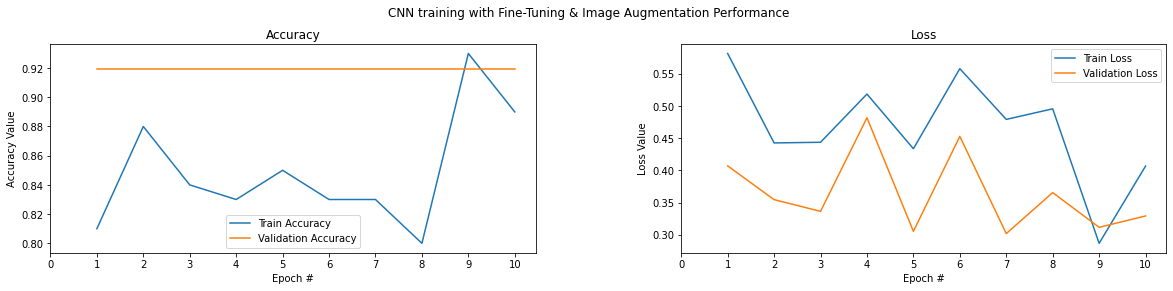

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('CNN training with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


**Loading the saved model**

Now, just to testify we will load our previously saved model, and make prediction on the test data. In addition, after getting the predicted values we will produce a **confusion matrix**.

In [ ]:
model_load = tf.keras.models.load_model("/content/drive/MyDrive/DATA/DeepVideos/deepfake-detection-model.h5")

True positive =  5823
False positive =  0
False negative =  510
True negative =  0




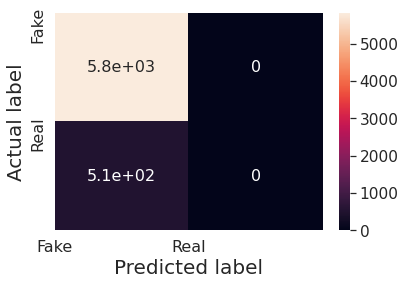

In [ ]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()


imag_pred = []
y = []

for fn in os.listdir("/content/drive/MyDrive/DATA/DeepVideos/train_Data"):
  # predicting images
  for i in os.listdir("/content/drive/MyDrive/DATA/DeepVideos/train_Data/" + fn):
    if fn == "fake":
      y.append(0)
    elif fn == "real":
      y.append(1)
    path = "/content/drive/MyDrive/DATA/DeepVideos/train_Data/" + fn + "/" + i
    img = image.load_img(path, target_size=(48,48))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    
    imag_pred.append(round(model_load.predict(images)[0][0]))

    
print_confusion_matrix(y, imag_pred)